In [4]:
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import math

In [5]:
path = "/home/francisco/tps/datos/tp2/"
load_path = path + "{}.hdf"

electrodos = [8, 44, 80, 131, 185]

N_P = 3
N_S = 3
pacientes_P = []
pacientes_S = []
for load_name, N, dest, offset in [("P", N_P, pacientes_P, 0), ("S", N_S, pacientes_S, 10)]:
    for i in range(1, 1 + N):
        paciente = load_name + "{:02d}".format(i)
        df_ = pd.read_hdf(load_path.format(paciente))
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        dest.append(df_)


In [6]:
# Calcular N para hacer la transformación simbólica
min_value = 2**32
max_value = -2**32
max_n_sigma = (-1, None)

for pacientes in [pacientes_P, pacientes_S]:
    for df_paciente in pacientes:
        for idx, df_ in df_paciente.groupby(["paciente", "epoch", "sensor"]):
            s = df_["valores"]
            min_value = min(s.min(), min_value)
            max_value = max(s.max(), max_value)
            max_n_sigma = max((len(s), s.std()), max_n_sigma)
            
print(min_value, max_value, max_n_sigma)


-0.000134124962507 0.000190491369934 (201, 0.00010227410079856466)


In [23]:
N = math.ceil((max_value - min_value) / (max_n_sigma[1] * max_n_sigma[0] ** (-1/3)))
print(N)
step = (max_value - min_value) / (N-1)
print(step)

19
1.80342406912e-05


In [25]:
def transformacion_simbolica(v):
    simbolos = (v - min_value) // step
    simbolos[simbolos == N] = N - 1
    return simbolos
    
for pacientes in [pacientes_P, pacientes_S]:
    for df_p in pacientes:
        df_p["simbolo"] = df_p.groupby(["paciente", "epoch", "sensor"]).apply(transformacion_simbolica)

In [34]:
pacientes_P[0].head()

valores  simbolo
paciente epoch sensor tiempo                       
0        0     8      0      -2.156435e-06      7.0
                      1      -5.516751e-07      7.0
                      2       2.121832e-06      7.0
                      3       4.735732e-06      7.0
                      4       5.841685e-06      7.0

In [54]:
def calcular_informacion(df_):
    s = df_["simbolo"]
    p_simbolos = [s[s == simb].count() / len(s) for simb in range(N)]
    return -sum([p * np.log(p) if p != 0 else 0 for p in p_simbolos])

entropias_P = []
entropias_S = []
for pacientes, entropias in [(pacientes_P, entropias_P), (pacientes_S, entropias_S)]:
    for i, df_p in enumerate(pacientes):
        print(i)
        s_e = df_p.groupby(["paciente", "epoch", "sensor"]).apply(calcular_informacion)
        entropias.append(s_e)


0
1
2
0
1
2


In [65]:
prom_entropias_P = []
prom_entropias_S = []
for entropias, prom_entropias in [(entropias_P, prom_entropias_P), (entropias_S, prom_entropias_S)]:
    for s in entropias:
        prom_entropias.append(s.groupby(["sensor"]).mean())

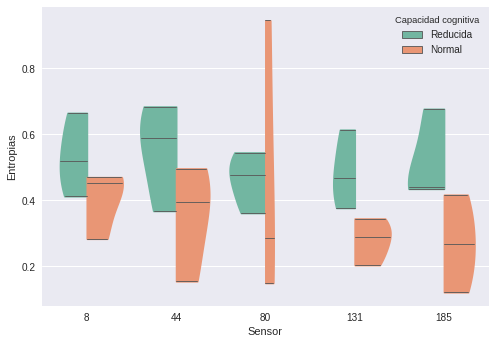

In [72]:

df_punto_a = pd.DataFrame({
    "Entropias": [x for s in (prom_entropias_P + prom_entropias_S) for x in s.values],
    "Capacidad cognitiva": ["Reducida" for s in prom_entropias_P for x in s.values] + ["Normal" for s in prom_entropias_P for x in s.values],
    "Sensor": [x for s in (prom_entropias_P + prom_entropias_S) for x in s.index]
})

sns.violinplot(x="Sensor", y="Entropias", hue="Capacidad cognitiva", data=df_punto_a, 
               split=True, palette="Set2", inner="stick", cut=0)
sns.plt.show()